In [1]:
# Dependencies
import requests, re, traceback, sys
import urllib.parse as urlp
from graphviz import Digraph
from bs4 import BeautifulSoup as bs
from palettable.tableau import Tableau_20
from tqdm import trange

In [2]:
# Control what logs to pring
# 0: print nothing
# 1: print errors
# 2: print logs
DEBUG_LEVEL=0
print_errors = False

In [3]:
base_url = "https://en.wikipedia.org/"
redirects = {}
house_color_map = Tableau_20.hex_colors

In [4]:
# Mapping of what words in the Wikipedia info box represent
# what kind of relationship. 
# Please expand if you find any new ones.

predecessor_labels = ["Preceded", "Predecessor"]
sucessor_labels = ["Successor", "Succeeded"]
issue_labels = ["Child", "Issue"]
parents = ["Parent", "Mother", "Father"]
house_labels = ["Allegiance","Political party", "House"]
spouse_labels = ["Husband", "Wife", "Spouse"]

In [5]:
# random utility functions

def setdebuglevel(level): 
    DEBUG_LEVEL=level

redify = lambda s: "\x1b[31m"+s+"\x1b[0m"
flattened = lambda l: [item for sublist in l for item in sublist]
log = lambda *args: print(*args) if DEBUG_LEVEL > 1 else None
error = lambda *args: print(*args) if DEBUG_LEVEL > 0 and print_errors else None

In [6]:
# These classes contain the information about the people. 
# "Person" is for when we've successfully gotten all the data.
# "Peon" is for when there's no data, either haven't scraped
# it yet, or ran into some kind of error.

# IMPORTANT NOTE: Throughout this code, the Wikipedia link 
# acts as the ID for each person.
def trim_url(path):
    endpath = '/wiki/' + path.split('wiki/')[-1]
    return endpath

class Person:
    def __init__(self, name, path):
        self.name = name
        self.path = trim_url(path)
        self.titles = None
        self.parents = []
        self.spouse = []
        self.issue = []
        self.successor = []
        self.predecessor = []
        self.house = None
    def __repr__(self):
        return "Person(%s, %s)" % (self.name, self.path)
    def __eq__(self, other):
        if isinstance(other, Person):
            return (self.path.split(',')[0].lower() == other.path.split(',')[0].lower())
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.path)
        
class Peon:
    def __init__(self, name, path = ''):
        self.name = name
        self.path = trim_url(path)
    def __repr__(self):
        return "Peon(%s, %s)" % (self.name, self.path)
    def __eq__(self, other):
        if isinstance(other, Peon):
            return (self.path.split(',')[0].lower() == other.path.split(',')[0].lower())
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.path)

In [7]:
# Queue class for keeping track of people.
# New people are added for each relationship, so long as 
# they're not a) already in the queue b) already processed.
# Can be added either by staging then committing, or just 
# by pushing. 
# Do not currently remember why stage -> commit setup exists.
# TODO: work out why stage -> commit setup exists.

class Queue:
    def __init__(self):
        self.to_create = []
        self.new = set()
        self.finished = []
    def stage(self, p):
        self.new.add(p)
    def commit(self):
        tmp = list(self.new.difference(set(self.finished)))
        self.to_create += tmp
        self.new = set()
    def push(self, p):
        if p not in self.finished:
            self.to_create.append(p)
    def pop(self):
        offer = self.to_create.pop(0)
        self.finished.append(offer)
        return offer
    def refresh(self):
        self.new = set()

In [8]:
# Take a row from the infobox and extract the useful data.
# Useful data = wikipedia links. The link itself acts as 
# the ID for a new person, while the text of the link is
# the display name.
def make_singleton(elem, queue):
    refs = elem.find_all('a')
    if len(refs) >= 1:
        ret = urlp.unquote(refs[0]['href'])
        peon = Peon(refs[0].text, ret)
    else:
        ret = elem.text
        peon = Peon(ret)
    queue.stage(peon)
    return ret
    
def make_list(elem, queue):
    refs = elem.find_all('a')
    ret = []
    for ref in refs:
        r = urlp.unquote(ref['href'])
        queue.stage(Peon(ref.text, r))
        ret.append(r)
    return ret
        

In [9]:


# Given a wikipedia link, fetch the HTML and extract the `infobox` section
def get_infocard(path):
    resp = requests.get(base_url + path)
    txt = resp.text
    s = bs(txt)
    p = r'\"wgPageName\":\"(.+?)\"'
    endpath = '/wiki/' + re.search(p, txt).group(1)
    infocard = s.find_all("table", class_ = "infobox")[0]
    name = s.title.string.replace(' - Wikipedia', '')
    return name, infocard, endpath

In [10]:
# Given a new person, extract relevant relationships from Wikipedia
def get_person(path, name, people, queue, onlytitled = False):
    queue.refresh()
    if path is None:
        log(redify("No path supplied:"), name)
        return False
    try:
        name, info, endpath = get_infocard(path)
        if endpath != path:
            log(redify("Redirect:"), path, '->', endpath)
            redirects[path] = endpath
            path = endpath
        person = Person(name, path)
        if person in people:
            log(redify("Already Exists:"), name, path)
            return True
        rows = info.find_all("tr")
        if 'img' in [x.name for x in rows[1].descendants]:
            person.titles = rows[2].text
        elif onlytitled:
            raise Exception('Untitled.')
        for r in rows:
            if len(r.contents) == 2 and r.contents[0].name == 'th':
                # TODO: principle of reuse. Also, extensibility.
                # ie: one extraction/assignment function that can be used for
                # many relationships.
                if any([word in r.contents[0].text for word in parents]):
                    person.parents = person.parents + make_list(r.contents[1], queue)
                elif any([word in r.contents[0].text for word in issue_labels]):
                    person.issue = person.issue + make_list(r.contents[1], queue)
                elif any([word in r.contents[0].text for word in spouse_labels]):
                    person.spouse = person.spouse + make_list(r.contents[1], queue)
                elif any([word in r.contents[0].text for word in house_labels]):
                    person.house = make_singleton(r.contents[1], queue)
                elif any([word in r.contents[0].text for word in predecessor_labels]):
                    person.predecessor = person.predecessor + make_list(r.contents[1], queue)
                elif any([word in r.contents[0].text for word in sucessor_labels]):
                    person.successor = person.successor + make_list(r.contents[1], queue)
        people.add(person)
        log("Adding", len(queue.new), "new elements")
        queue.commit()
        return True
    except IndexError:
        error("    ", redify("Invalid - "), path)
    except Exception as e:
        error("    ", redify("Error - "), path + ":", e)
        traceback.print_exc(file=sys.stdout)
        return False
    

In [11]:

# Starting with the basis_person, collect information and relationships, 
# and add related people to the queue. Go through `count` people.
# Return list of completed people.
def collect_people(basis_person_name, basis_person_link, count=150):
    people = set()
    queue = Queue()
    queue.stage(Peon(basis_person_name, basis_person_link))
    queue.commit()
    for i in trange(count):
        peon = queue.pop()
        worked = get_person(peon.path, peon.name, people, queue)
        if not worked:
            people.add(peon)
        log(peon.name)
    return people

In [12]:
# Remove extra marriage link (helps for removing edges)
def one_marriage_to_rule_them_all(marriage):
    cleaned = []
    for bond in marriage:
        if bond not in cleaned and (bond[1], bond[0]) not in cleaned:
            cleaned.append(bond)
    return cleaned

# Get actual link from redirected links
def final(x):
    return redirects[x] if x in redirects else x

# Transform list of people into graph of relations
# List of people (nodes) and lists of edges (child relationships, marriage, crown pathways)
def make_nodegraph_parts(people):
    nodes = []
    childrels = set()
    marriage = set()
    crown = set()

    relevant_people = [p for p in people if isinstance(p, Person)]
    for person in relevant_people:
        nodes.append((person.path, person.name, person.house))
        childrels.update({(person.path, final(x)) for x in person.issue})
        marriage.update({(person.path, final(x)) for x in person.spouse})
        crown.update({(person.path, final(x)) for x in person.successor})
        crown.update({(final(x),person.path) for x in person.predecessor})
        childrels.update({(final(x),person.path) for x in person.parents})

    nodelinks = [x[0] for x in nodes]
    crown = [x for x in crown if x[0] in nodelinks and x[1] in nodelinks]
    marriage = [x for x in marriage if x[0] in nodelinks and x[1] in nodelinks]
    childrels = [x for x in childrels if x[0] in nodelinks and x[1] in nodelinks]

    marriage = one_marriage_to_rule_them_all(marriage)
    
    return nodes, childrels, marriage, crown

In [13]:
# Functions to remove non-cycle elements, so that the circular ones are really highlighted
# TODO: can probably be improved by using find-cycles graph functions instead of recursing on find-leafs

# Find unimportant people (with only one relation; graph edges)
def get_leafs(nodes, crown, marriage, childrels):
    nodepaths = crown + marriage + childrels
    relinstances = flattened(nodepaths)
    relinstances_notkids = flattened(crown + marriage) + [x[0] for x in childrels]
    leafs = [x[0] for x in nodes if relinstances.count(x[0]) < 2]
    leafs += [x for x in relinstances_notkids if relinstances_notkids.count(x) == 0]
    return list(set(leafs))

# Remove unimportant people
def remove_leafs(nodes, crown, marriage, childrels, leafs):
    nodes = [x for x in nodes if x[0] not in leafs]
    crown = [x for x in crown if x[0] not in leafs and x[1] not in leafs]
    marriage = [x for x in marriage if x[0] not in leafs and x[1] not in leafs]
    childrels = [x for x in childrels if x[0] not in leafs and x[1] not in leafs]
    return nodes, crown, marriage, childrels
    
# Recursively find and remove unimportant people
def prune(nodes, crown, marriage, childrels, backoff_limit=10):
    leafs = get_leafs(nodes, crown, marriage, childrels)
    while len(leafs)>0 and backoff_limit > 0:
        nodes, crown, marriage, childrels = remove_leafs(nodes, crown, marriage, childrels, leafs)
        log("Removed", len(leafs), "leaves")
        leafs = get_leafs(nodes, crown, marriage, childrels)
    return nodes, crown, marriage, childrels

In [14]:
# Combination of above functions 
# Input: the initial basis person
# Output: the nodelist/edgelist graph representation
def get_graph(basis_person_name, basis_person_link, count=150, pruneit = True):
    people = collect_people(basis_person_name, basis_person_link, count)
    log("Collected", len(people), "people")
    nodes, childrels, marriage, crown = make_nodegraph_parts(people)
    log("Turned into", len(nodes), "nodes")
    if pruneit:
        nodes, childrels, marriage, crown = prune(nodes, childrels, marriage, crown)
        log("Pruned into", len(nodes), "nodes")
    return nodes, childrels, marriage, crown

In [15]:
# Assign colors to houses.
# 20-color palette, so only pick the 20 most common houses.
def get_house_colors(houses):
    top_houses = sorted([(x, houses.count(x)) for x in set(houses) if x is not None], 
                        key=lambda x: x[1], reverse=True)[:20]
    house_colors = {top_houses[i][0]:house_color_map[i] for i in range(len(top_houses))}
    return house_colors

# Create graphical diagraph
# Input: nodelist/edgelists
# Output: graphziz diagram
def create_diagraph(nodes, childrels, marriage, crown, name="WikiRelations"):
    house_colors = get_house_colors([x[2] for x in nodes]) # accurate house count after pruning
    dot = Digraph(name=name)

    for p, n, h in nodes:
        dot.node(p, n, color = house_colors.get(h, "black"))

    for a, b in list(marriage):
        dot.edge(a, b, color = 'red', style = 'dashed', arrowhead = 'none')
    for a, b in list(crown):
        dot.edge(a, b, color = 'gold')
    for a, b in list(childrels):
        dot.edge(a, b, color = 'black')
        
    return dot

In [16]:
# Entry function to tie everything together.
# Inputs: Name and link to person you're interested in.
# Outputs: Pretty graph of their relationships. Also saves to disk.

def wiki_relationship_diagraph(name, link, count=150,
                               title="WikiRelations", trim=True, save=True, save_format=False):
    nodes, childrels, marriage, crown = get_graph(title, link, count, trim)
    dot = create_diagraph(nodes, childrels, marriage, crown)
    
    if save_format:
        dot.format = save_format
    if save:
        dot.render(title)
    return dot

Adding 4 new elements
WikiRelations
Redirect: /wiki/Berenice_III_of_Egypt -> /wiki/Berenice_III
Adding 7 new elements
Berenice III
Adding 4 new elements
Ptolemy X Alexander I
Redirect: /wiki/Ptolemy_XII -> /wiki/Ptolemy_XII_Auletes
Adding 13 new elements
Ptolemy XII
Adding 13 new elements
Cleopatra Selene
Already Exists: Ptolemy X Alexander I /wiki/Ptolemy_X_Alexander_I
Ptolemy X
Adding 7 new elements
Ptolemy IX Soter
Redirect: /wiki/Cleopatra_V_of_Egypt -> /wiki/Cleopatra_V
Adding 9 new elements
Cleopatra V of Egypt
Royal titulary
Prenomen  (Praenomen)
Already Exists: Cleopatra Selene of Syria /wiki/Cleopatra_Selene_of_Syria
Cleopatra Selene
Adding 9 new elements
Ptolemy VIII Physcon
Already Exists: Cleopatra V /wiki/Cleopatra_V
Cleopatra V
Redirect: /wiki/Cleopatra_III_of_Egypt -> /wiki/Cleopatra_III
Adding 9 new elements
Cleopatra III of Egypt
Adding 3 new elements
Ptolemy XIII Theos Philopator
Already Exists: Ptolemy IX Soter /wiki/Ptolemy_IX_Soter
Ptolemy IX Soter
Redirect: /wiki/

Already Exists: Antiochus XII Dionysus /wiki/Antiochus_XII_Dionysus
Antiochus XII
Adding 4 new elements
Seleucus V
Already Exists: Philip I Philadelphus /wiki/Philip_I_Philadelphus
Philip I
Laodice, Queen of Commagene
Already Exists: Tryphaena /wiki/Tryphaena
Tryphaena
Adding 5 new elements
Demetrius III
Already Exists: Seleucus VI Epiphanes /wiki/Seleucus_VI_Epiphanes
Seleucus VI
Already Exists: Cleopatra Thea /wiki/Cleopatra_Thea
Cleopatra Thea
Already Exists: Ptolemy of Cyprus /wiki/Ptolemy_of_Cyprus
Ptolemy of Cyprus
Redirect: /wiki/Antiochus_X -> /wiki/Antiochus_X_Eusebes
Already Exists: Antiochus X Eusebes /wiki/Antiochus_X_Eusebes
Antiochus X
Already Exists: Antiochus X Eusebes /wiki/Antiochus_X_Eusebes
Antiochus X
Already Exists: Philip II Philoromaeus /wiki/Philip_II_Philoromaeus
Philip II
Already Exists: Antiochus VIII Grypus /wiki/Antiochus_VIII_Grypus
Antiochus VIII
Already Exists: Tryphaena /wiki/Tryphaena
Tryphaena
Already Exists: Demetrius III Eucaerus /wiki/Demetrius_II

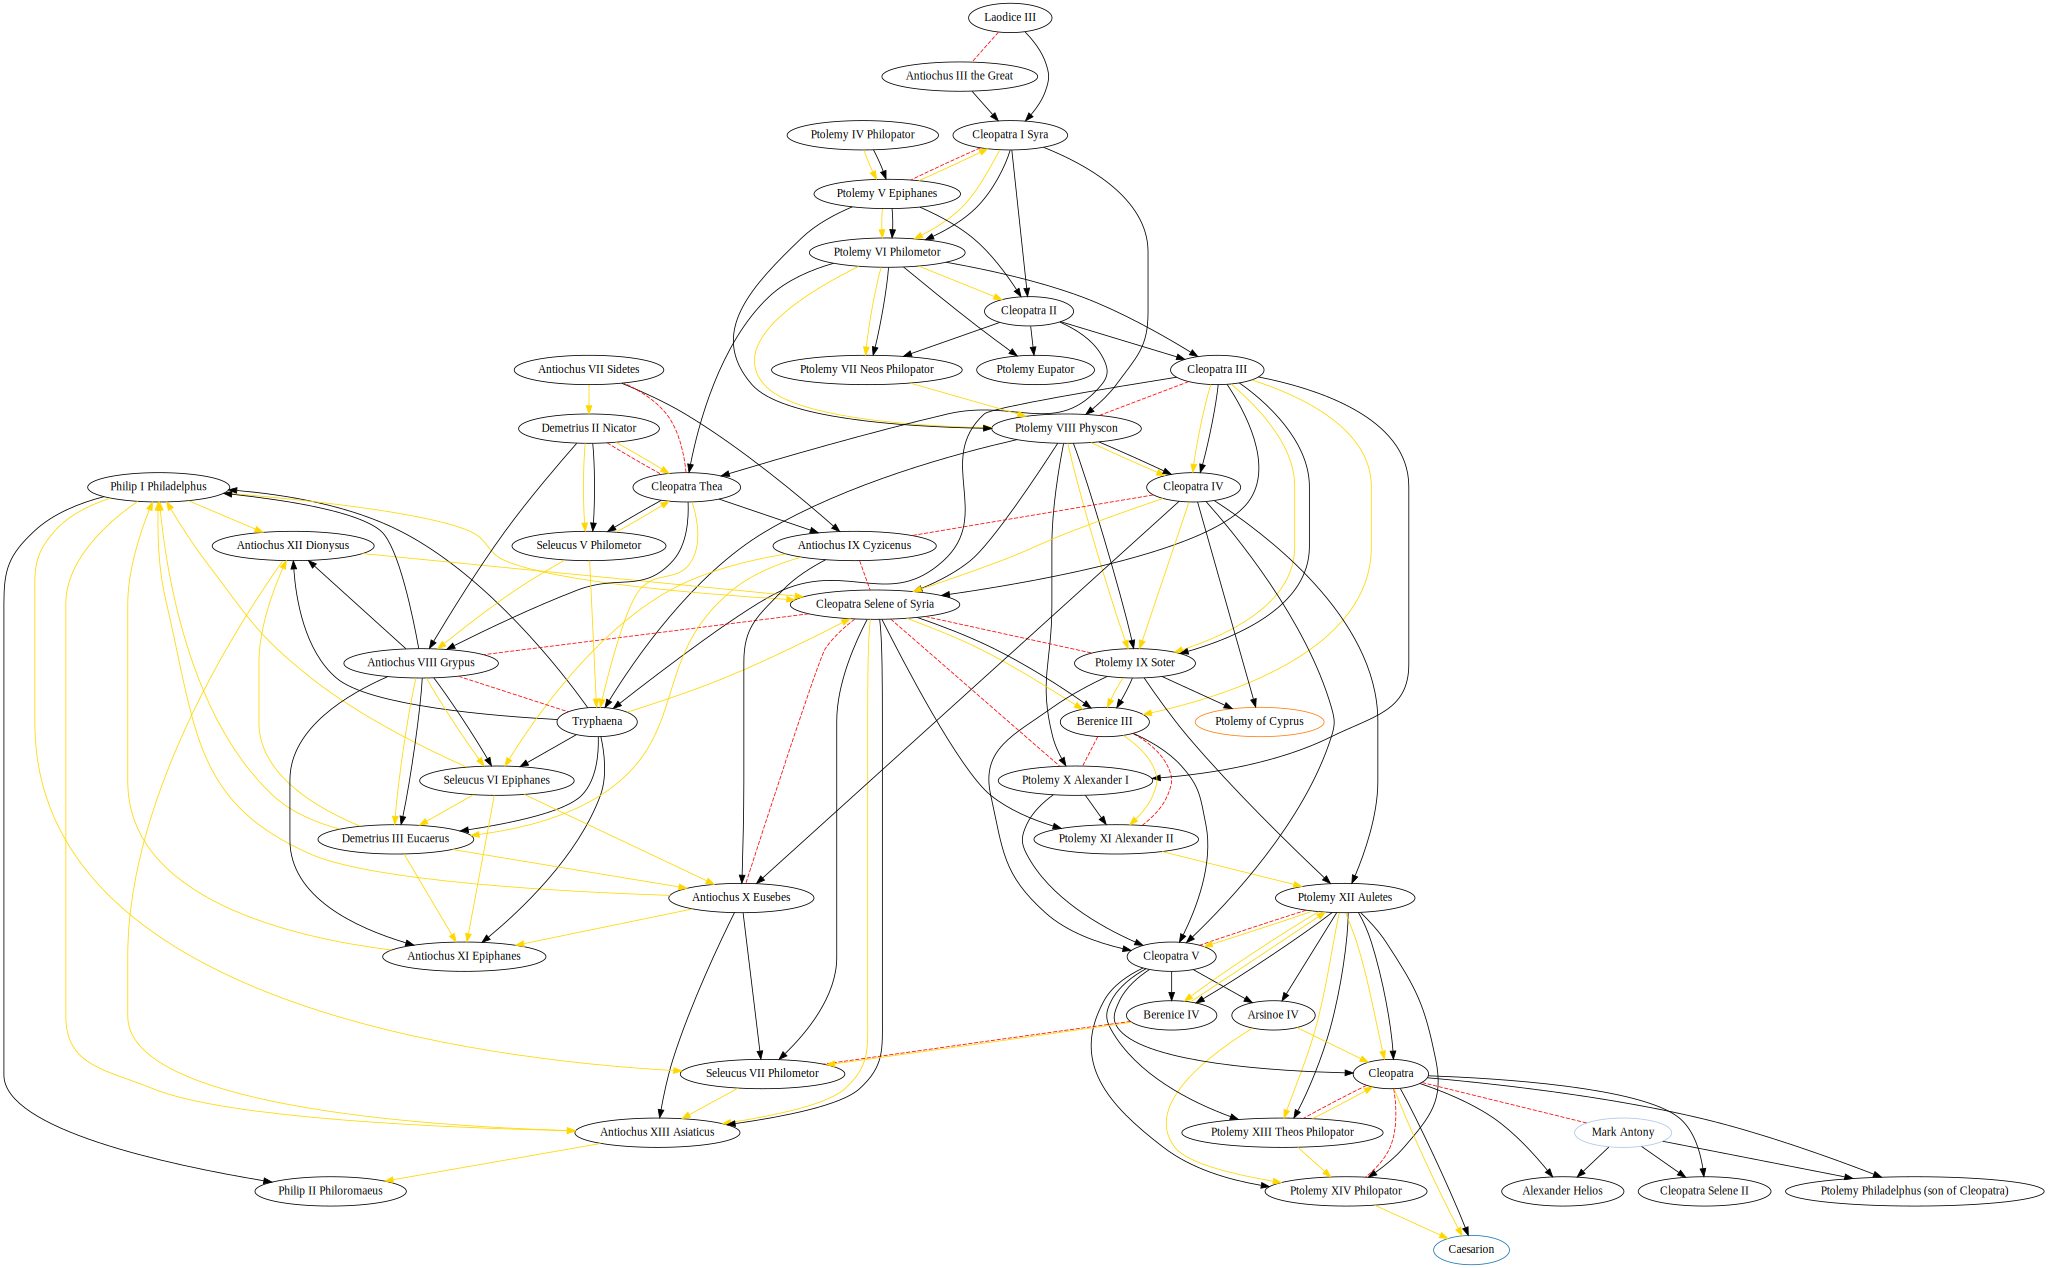

In [17]:





# QuickStart Example 

dot = wiki_relationship_diagraph(
    name = "Ptolemy XI", 
    link = "https://en.wikipedia.org/wiki/Ptolemy_XI_Alexander_II"
)







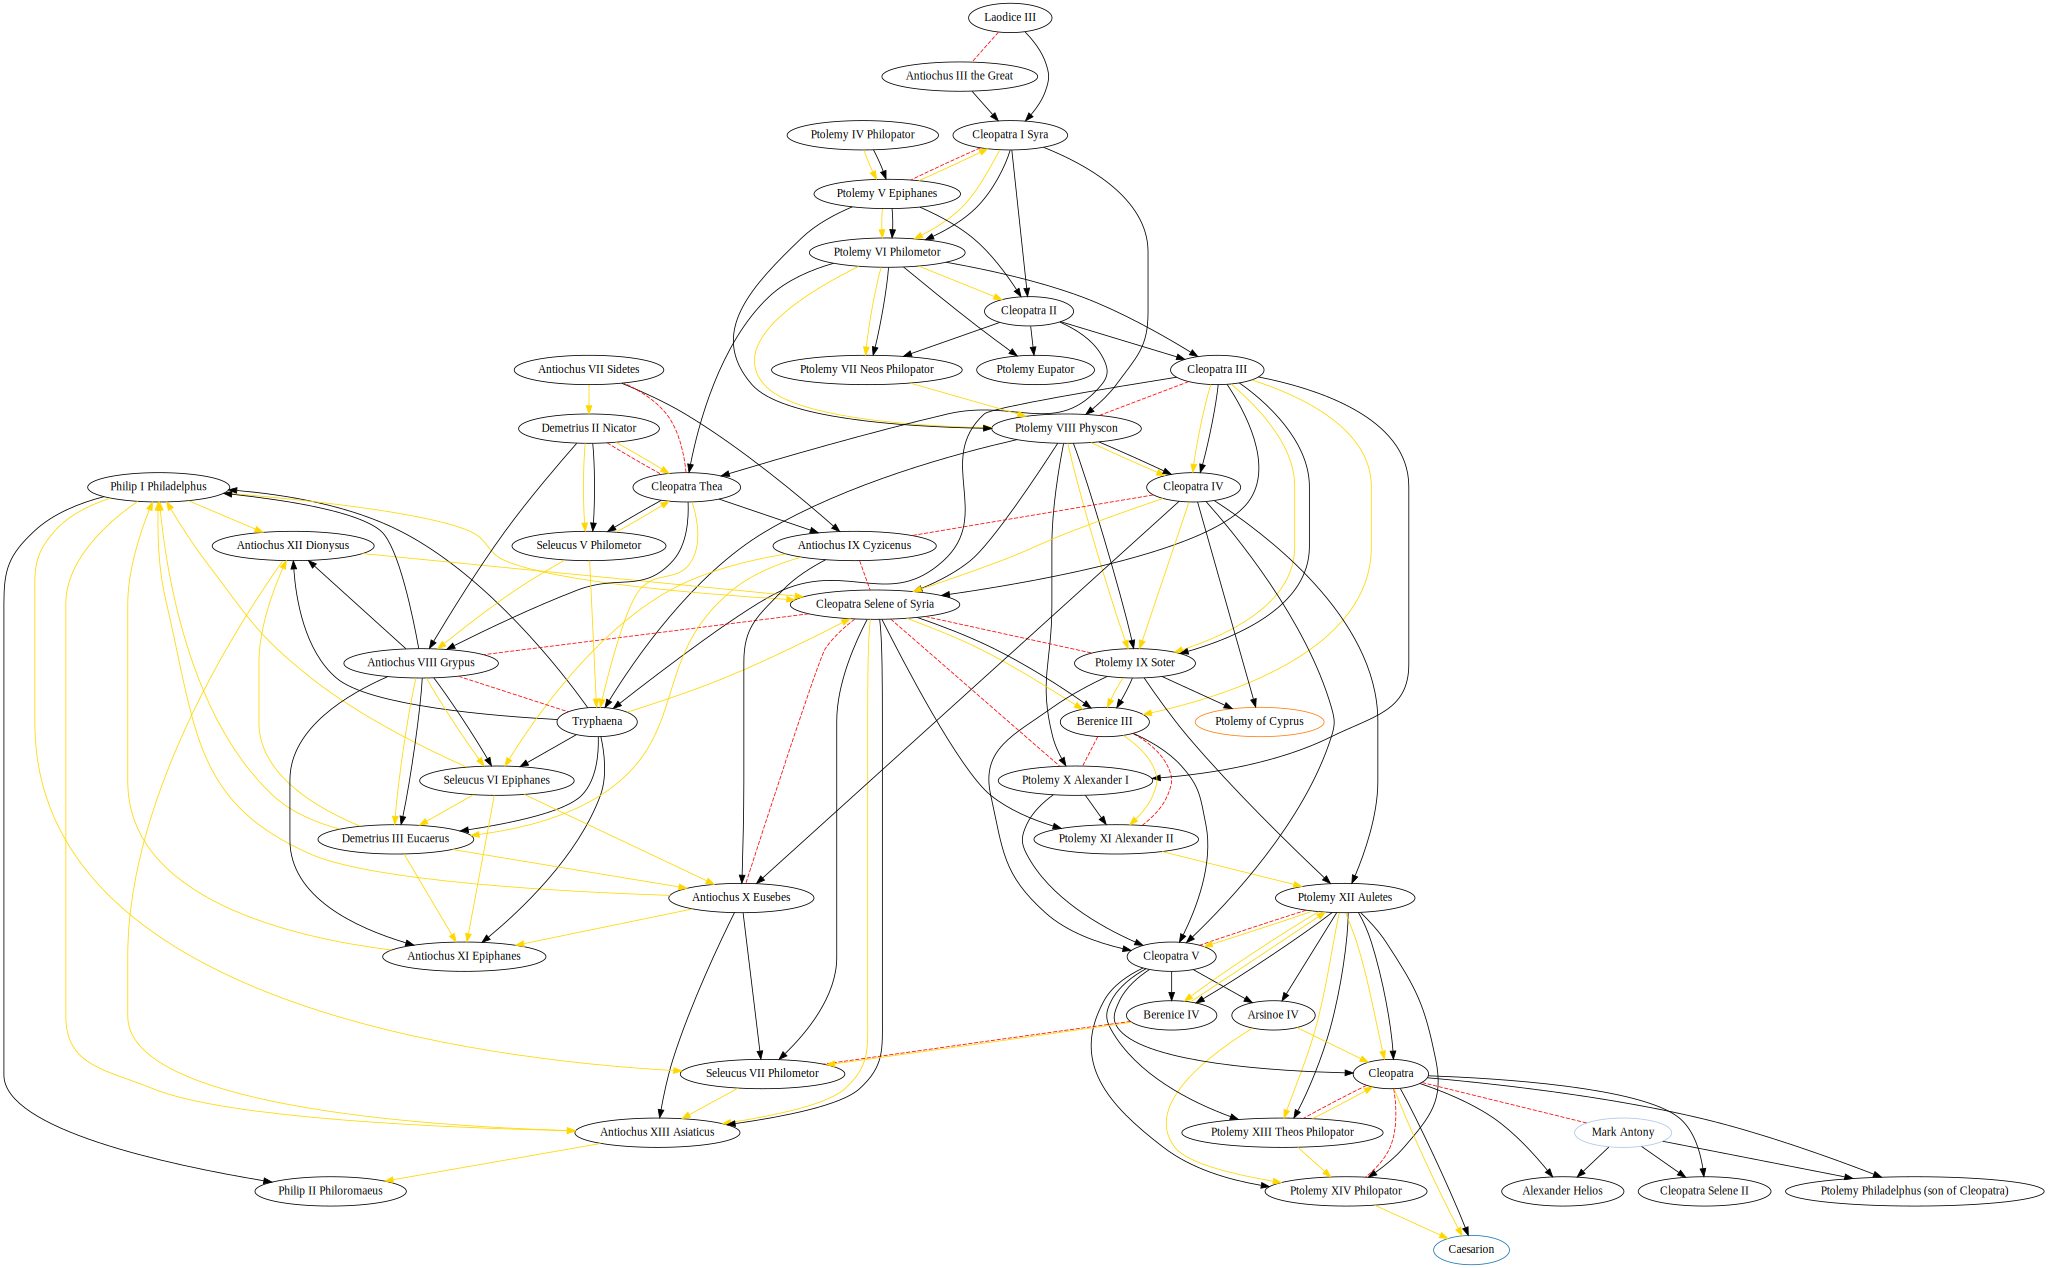

In [19]:



# Display graph from Quickstart Example

dot




In [18]:
# # Longform Example 
# See ReadMe for more info
# dot = wiki_relationship_diagraph("Ptolemy XI", "Ptolemy_XI_Alexander_II", 200, 
#                                  title="Ptolemies",
#                                  save_format='png',
#                                  trim = False
#                                 )